# Ejercicio 7: Q-learning

Comenzemos importando lo necesario

In [ ]:
!pip install -U gymnasium pygame moviepy
!pip install gymnasium[box2d]



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 836 kB 4.9 MB/s 
     |████████████████████████████████| 21.8 MB 2.4 MB/s 
     |████████████████████████████████| 388 kB 28.6 MB/s 
     |████████████████████████████████| 26.9 MB 1.7 MB/s 
  Created wheel for moviepy: filename=moviepy-1.0.3-py3-none-any.whl size=110742 sha256=86064b074b14ce240fd821cea93f2cf6862d120f0fa15bbb88120dfd01399680
  Stored in directory: /root/.cache/pip/wheels/56/dc/2b/9cd600d483c04af3353d66623056fc03faed76b7518faae4df
Successfully built moviepy
  Attempting uninstall: moviepy
    Found existing installation: moviepy 0.2.3.5
    Uninstalling moviepy-0.2.3.5:
      Successfully uninstalled moviepy-0.2.3.5
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.1 MB 5.2 MB/s 
     |████████████████████████████████| 18.3 MB 1.2 MB/s 
     |█

In [ ]:
import numpy as np
rng = np.random.default_rng()
import matplotlib.pyplot as plt
import os

import gymnasium as gym
print("gym version:", gym.__version__)

from moviepy.editor import ImageSequenceClip, ipython_display

class GymRecorder(object):
    """
    Simple wrapper over moviepy to generate a .gif with the frames of a gym environment.

    The environment must have the render_mode `rgb_array_list`.
    """
    def __init__(self, env):
        self.env = env
        self._frames = []

    def record(self, frames):
        "To be called at the end of an episode."
        for frame in frames:
            self._frames.append(np.array(frame))

    def make_video(self, filename):
        "Generates the gif video."
        directory = os.path.dirname(os.path.abspath(filename))
        if not os.path.exists(directory):
            os.mkdir(directory)
        self.clip = ImageSequenceClip(list(self._frames), fps=self.env.metadata["render_fps"])
        self.clip.write_gif(filename, fps=self.env.metadata["render_fps"], loop=1)
        del self._frames
        self._frames = []

def running_average(x, N):
    cumsum = np.cumsum(np.insert(np.array(x), 0, 0))
    return (cumsum[N:] - cumsum[:-N]) / N

gym version: 0.26.3


En este ejercicio usaremos Q-learning en el entorno Taxi que usamos anteriormente para probar los métodos de Monte Carlo.

Q-learning actualiza los valores Q despues de cada transición:

$\Delta Q(s_t,a_t) = \alpha(r_{t+1} + \gamma \max_{a'} Q(s_{t+1},a´) - Q(s_t,a_t))$

**Pregunta 1:** Actualice la clase que utilizo para control de Monte Carlo en el último ejercicio para que implemente Q-learning.

La principal diferencia es que el método update() tiene que ser llamado después de cada paso, no solo al final. Esto simplifica el código ya que no debe iterar por el episodio.

Use al principio los siguientes valores para los parámetros pero siéntase libre de cambiarlos después:

Factor de descuento $\gamma = 0.9$

Tasa de aprendizaje $\alpha = 0.1$

Selección de acciones epsilon-greedy action selection con probabilidad inicial de exploración 1.0 y decaimiento exponencial de $10^{-5}$ despues de cada paso.


Un número total de episodios 20000.

Mantenga la estructura de la clase: train() para el bucle principal y test() para correr un episodio sin exploración.

Gráfique el comportamiento durante el entrenamiento y la prueba. Visualice la estrategia aprendida por un episodio

Nota: si $s_{t+1}$ es un estado terminal ('done' es verdadero después de una transición), entonces el ajuste no debe ser hecho con respecto a $r_{t+1} + \gamma \, \max_{a'} \, Q(s_{t+1}, a')$ si no que $r_{t+1}$ ya que no hay siguiente accion.

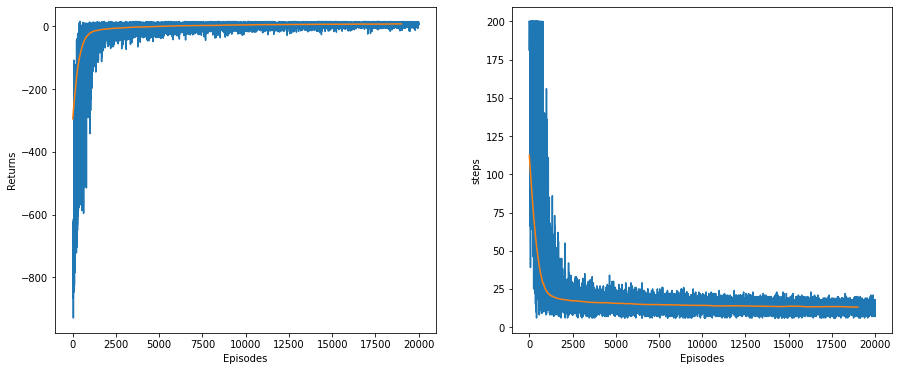

Test performance 7.857


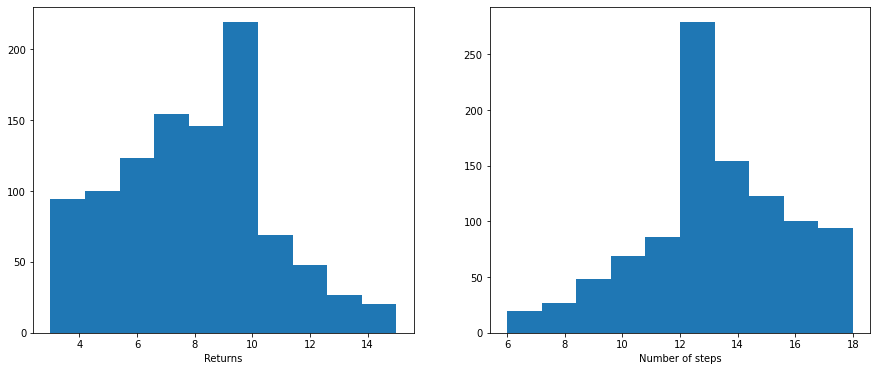

In [ ]:
class QLearningAgent:
    """
    Q-learning agent.
    """

    def __init__(self, env, gamma, epsilon, decay_epsilon, alpha):
        """
        :param env: gym-like environment
        :param gamma: discount factor
        :param epsilon: exploration parameter
        :param decay_epsilon: exploration decay parameter
        :param alpha: learning rate
        """
        self.env = env
        self.gamma = gamma
        self.epsilon = epsilon
        self.decay_epsilon = decay_epsilon
        self.alpha = alpha

        # Q_table
        self.Q = np.zeros([self.env.observation_space.n, self.env.action_space.n])

    def act(self, state):
        "Returns an action using epsilon-greedy action selection."

        action = rng.choice(np.where(self.Q[state, :] == self.Q[state, :].max())[0])

        if rng.random() < self.epsilon:
            action = self.env.action_space.sample()

        return action

    def update(self, state, action, reward, next_state, done):
        "Updates the agent using a single transition."

        # Bellman target
        target = reward

        if not done:
            target += self.gamma * self.Q[next_state, :].max()

        # Update the Q-value
        self.Q[state, action] += self.alpha * (target - self.Q[state, action])

        # Decay epsilon
        self.epsilon = self.epsilon * (1 - self.decay_epsilon)


    def train(self, nb_episodes, recorder=None):
        "Runs the agent on the environment for nb_episodes. Returns the list of obtained returns."

        # Returns
        returns = []
        steps = []

        # Fixed number of episodes
        for episode in range(nb_episodes):

            # Reset
            state, info = self.env.reset()
            done = False
            nb_steps = 0

            # Store rewards
            return_episode = 0.0

            # Sample the episode
            while not done:

                # Select an action
                action = self.act(state)

                # Perform the action
                next_state, reward, terminal, truncated, info = self.env.step(action)

                # Learn from the transition
                self.update(state, action, reward, next_state, done)

                # Go in the next state
                state = next_state

                # Increment time
                nb_steps += 1
                return_episode += reward

                # End of the episode
                done = terminal or truncated

            # Record at the end of the episode
            if recorder is not None and episode == nb_episodes -1:
                recorder.record(self.env.render())

            # Store info
            returns.append(return_episode)
            steps.append(nb_steps)


        return returns, steps

    def test(self, recorder=None):
        "Performs a test episode without exploration."
        previous_epsilon = self.epsilon
        self.epsilon = 0.0

        # Reset
        state, info = self.env.reset()
        done = False
        nb_steps = 0
        return_episode= 0

        # Sample the episode
        while not done:
            action = self.act(state)
            next_state, reward, terminal, truncated, info = self.env.step(action)
            return_episode += reward
            state = next_state
            nb_steps += 1
            done = terminal or truncated

        self.epsilon = previous_epsilon

        if recorder is not None:
            recorder.record(self.env.render())

        return return_episode, nb_steps


# MAIN



# Parameters
gamma = 0.9
epsilon = 1.0
decay_epsilon = 1e-5
alpha = 0.1
nb_episodes = 20000

# Create the environment
env = gym.make("")

# Create the agent
agent = QLearningAgent(env, gamma, epsilon, decay_epsilon, alpha)

# Train the agent
returns, steps = agent.train(nb_episodes)

# Plot training returns
plt.figure(figsize=(15, 6))
plt.subplot(121)
plt.plot(returns)
plt.plot(running_average(returns, 1000))
plt.xlabel("Episodes")
plt.ylabel("Returns")
plt.subplot(122)
plt.plot(steps)
plt.plot(running_average(steps, 1000))
plt.xlabel("Episodes")
plt.ylabel("steps")
plt.show()

# Test the agent for 1000 episodes
test_returns = []
test_steps = []
for episode in range(1000):
    return_episode, nb_steps = agent.test()
    test_returns.append(return_episode)
    test_steps.append(nb_steps)
print("Test performance", np.mean(test_returns))

plt.figure(figsize=(15, 6))
plt.subplot(121)
plt.hist(test_returns)
plt.xlabel("Returns")
plt.subplot(122)
plt.hist(test_steps)
plt.xlabel("Number of steps")
plt.show()

MoviePy - Building file videos/taxi-trained-td.gif with imageio.



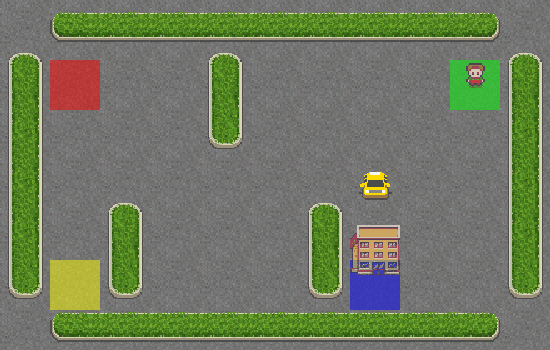

In [ ]:
env = gym.make("Taxi-v3", render_mode="rgb_array_list")
recorder = GymRecorder(env)
agent.env = env

return_episode, nb_steps = agent.test(recorder)

video = "videos/taxi-trained-td.gif"
recorder.make_video(video)
ipython_display(video, loop=1, autoplay=1)

**Pregunta 2:** Compare Q-learning con Monte Carlo. Experimente con los parámetros (gamma, epsilon, alpha, etc.).

**Respuesta:** Q-learning acepta valores gamma más grandes que MC, ya que los retornos tienen menor varianza. Con los parámetros correctos Q-learning puede aprender más rápido.